# ESP32 + MLX90640: TensorFlow CNN for classification
### Подготовил: Степанюк Денис Борисович

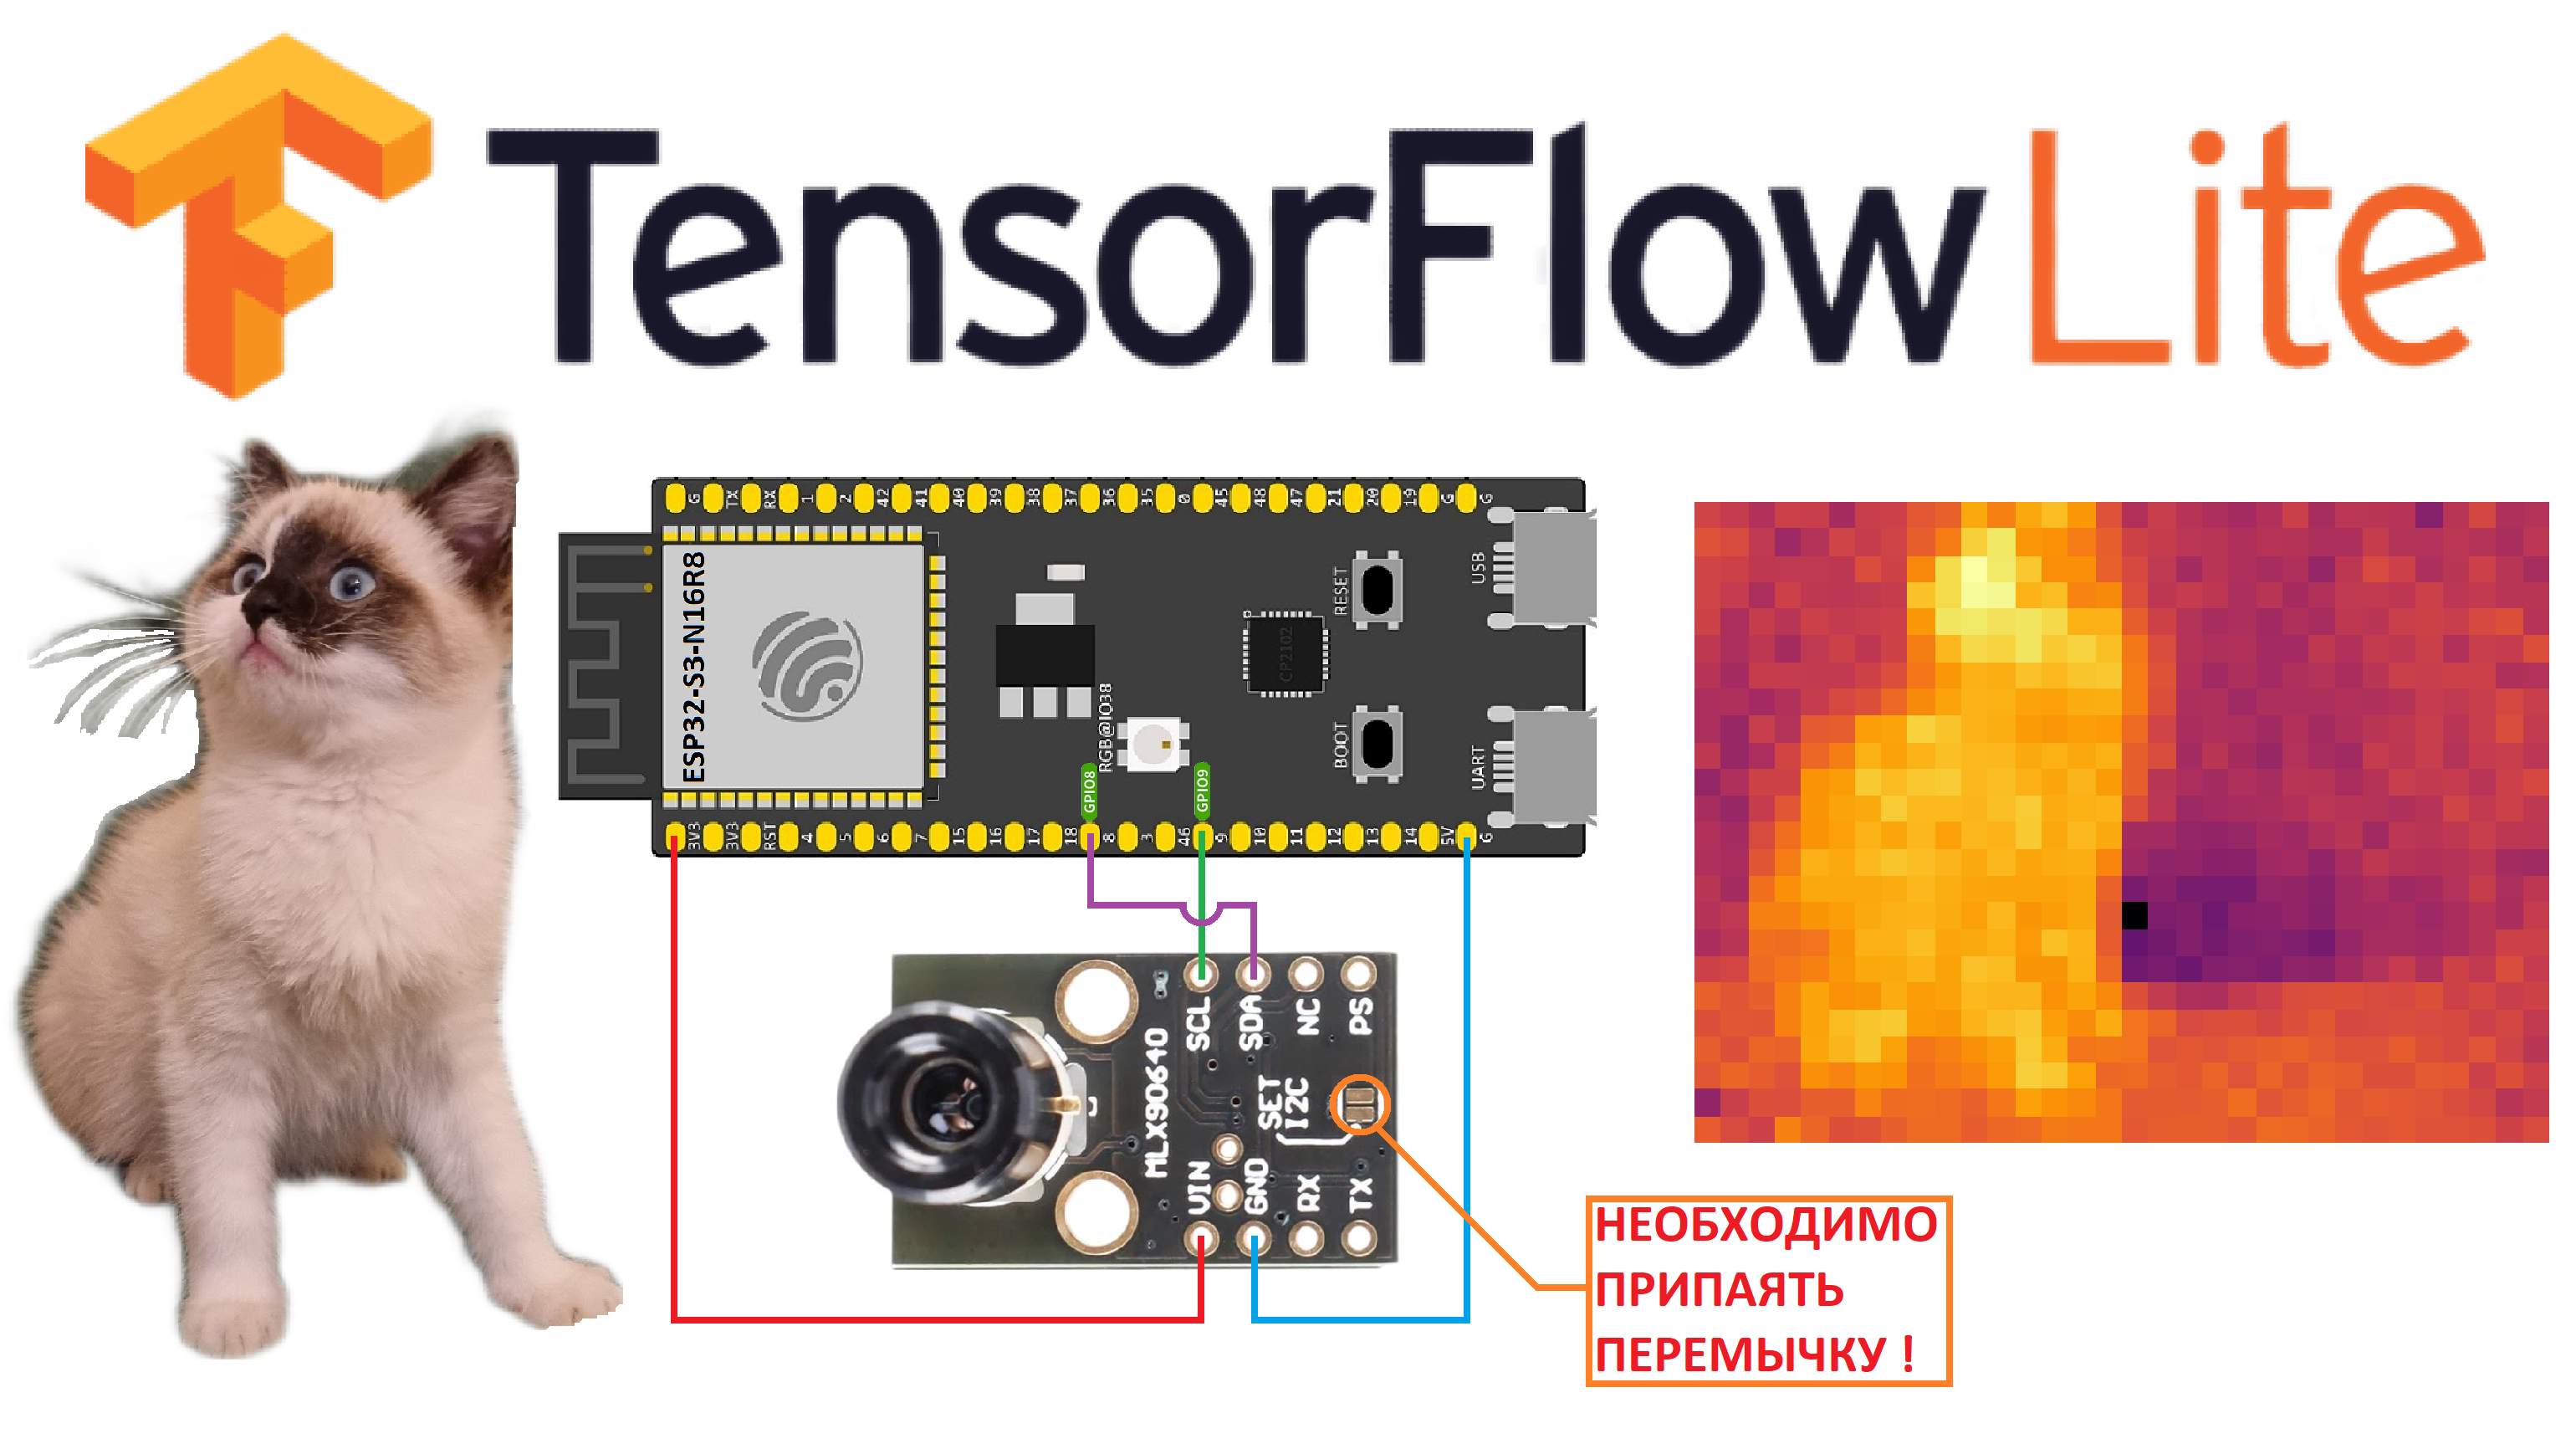

# Загрузка данных

In [1]:
import os

# Путь к папке с данными(фотографиями) для обучения.
DATASET_PATH = './Dataset'

# Размеры изображения:
IMAGE_HEIGHT = 24
IMAGE_WIDTH = 32
CHANNELS = 1

# Список сущностей для классификации.
LABELS = os.listdir(DATASET_PATH)
# Кол-во сущностей для классификации.
NUM_of_LABELS = len(LABELS)
print(LABELS, " :: ", NUM_of_LABELS)

['Cat', 'Empty', 'Human']  ::  3


In [2]:
import numpy as np
import pandas as pd

# Списки для хранения данных
X_data = []     # здесь будут numpy-массивы (термоизображения)
Y_labels = []   # здесь будут категории (строки)

# Проходим по всем категориям
for label in LABELS:
    folder_path = os.path.join(DATASET_PATH, label)
    print(f"📂 Папка: {folder_path}")

    if not os.path.exists(folder_path):
        print(f"⚠️ Папка {folder_path} не найдена!")
        continue

    # Список файлов .txt
    files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    print(f"   Найдено файлов: {len(files)}")

    # Обрабатываем каждый файл
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)

        # Читаем .txt файл без заголовков, с разделителем ","
        df = pd.read_csv(file_path, header=None)

        # Проверим форму — у тебя должна быть (24, 32)
        if df.shape != (IMAGE_HEIGHT, IMAGE_WIDTH):
            print(f"⚠️ Файл {file_name} имеет необычную форму: {df.shape}")
            continue

        # Преобразуем DataFrame в numpy-массив
        img_array = df.values.astype(np.float32)

        # Добавим измерение канала (например, (24,32,1))
        img_array = np.expand_dims(img_array, axis=-1)

        # Сохраняем в список
        X_data.append(img_array)
        Y_labels.append(label)

# Преобразуем списки в numpy-массивы
X_data = np.array(X_data)
Y_labels = np.array(Y_labels)
# Преобразуем категориальные текстовые метки (правильные ответы) в бинарные вектора.
Y_binary = pd.get_dummies(Y_labels)

print("✅ Загрузка завершена!")
print(f"Форма X_data: {X_data.shape}")   # (N, 24, 32, 1)
print(f"Форма Y_labels: {Y_labels.shape}")  # (N,)
print("Пример меток:", np.unique(Y_labels))

📂 Папка: ./Dataset\Cat
   Найдено файлов: 51
📂 Папка: ./Dataset\Empty
   Найдено файлов: 47
📂 Папка: ./Dataset\Human
   Найдено файлов: 52
✅ Загрузка завершена!
Форма X_data: (150, 24, 32, 1)
Форма Y_labels: (150,)
Пример меток: ['Cat' 'Empty' 'Human']


# Визуализация данных (термоизображений)

NUM_of_LABELS: 3
LABELS: ['Cat' 'Empty' 'Human']
📊 X_data shape: (150, 24, 32, 1)
📊 Y_labels shape: (150,)


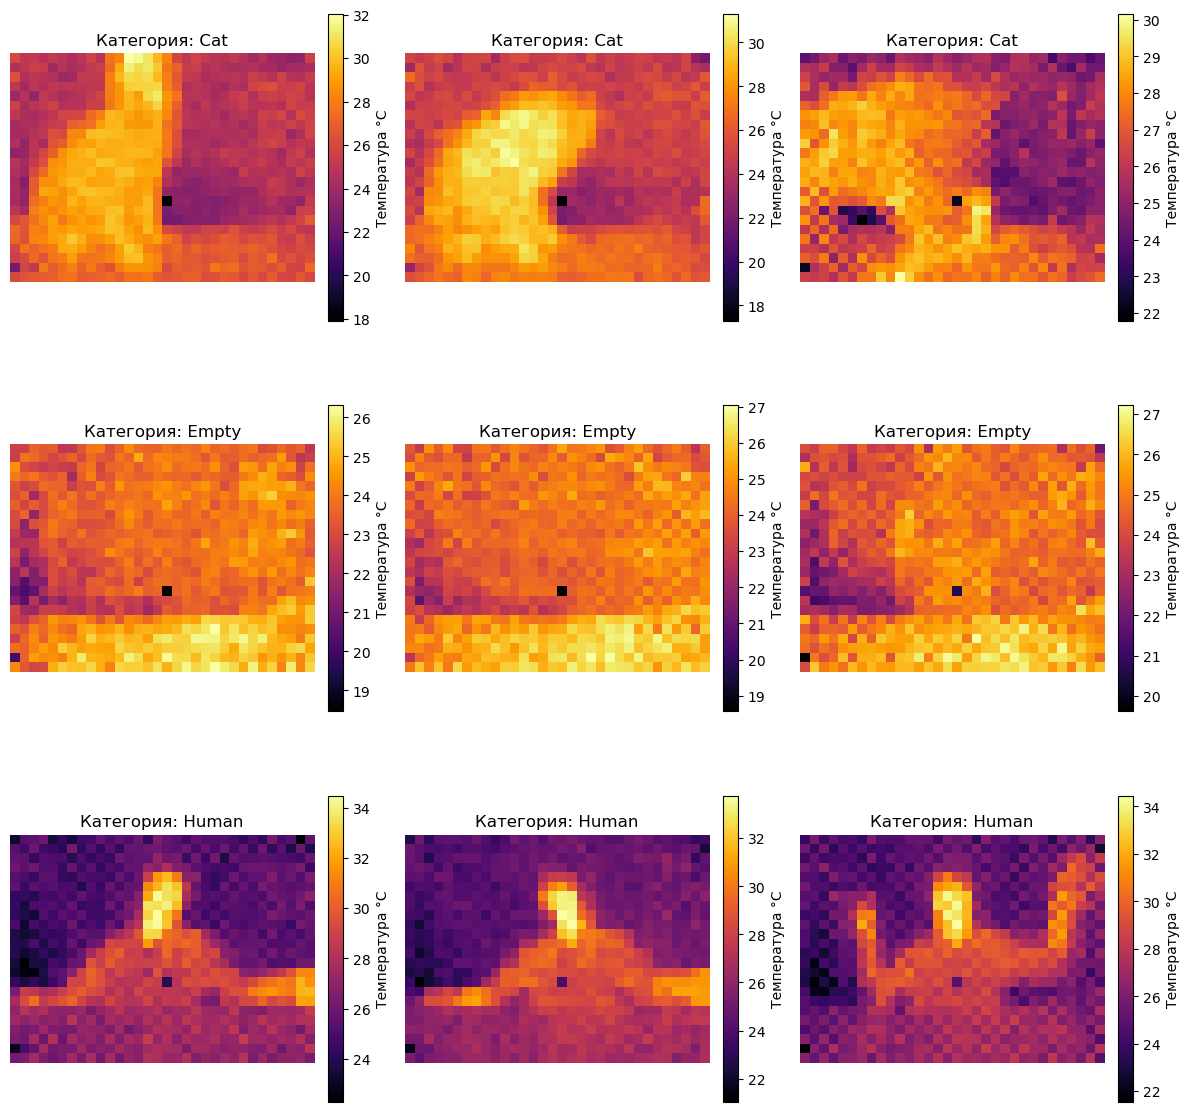

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Кол-во сущностей
print("NUM_of_LABELS:", NUM_of_LABELS)
print("LABELS:", np.unique(Y_labels))

# Проверим, что данные загружены
print("📊 X_data shape:", X_data.shape)
print("📊 Y_labels shape:", Y_labels.shape)

# Уникальные категории
unique_labels = np.unique(Y_labels)

# Настраиваем размер фигуры
plt.figure(figsize=(12, 4 * len(unique_labels)))

# Счётчик позиции для subplot
plot_index = 1

for label in unique_labels:
    # Индексы изображений для текущего лейбла
    idx = np.where(Y_labels == label)[0]
    
    # Берём только первые 3 (если есть меньше — то все)
    chosen = idx[:3]
    
    for j in chosen:
        plt.subplot(len(unique_labels), 3, plot_index)
        img = X_data[j, :, :, 0]
        plt.imshow(img, cmap='inferno')
        plt.colorbar(label='Температура °C', fraction=0.046, pad=0.04)
        plt.title(f"Категория: {label}")
        plt.axis('off')
        plot_index += 1

plt.tight_layout()
plt.show()

# Подготовка данных
### Масштабируем данные из float в int8 [-128, 127]
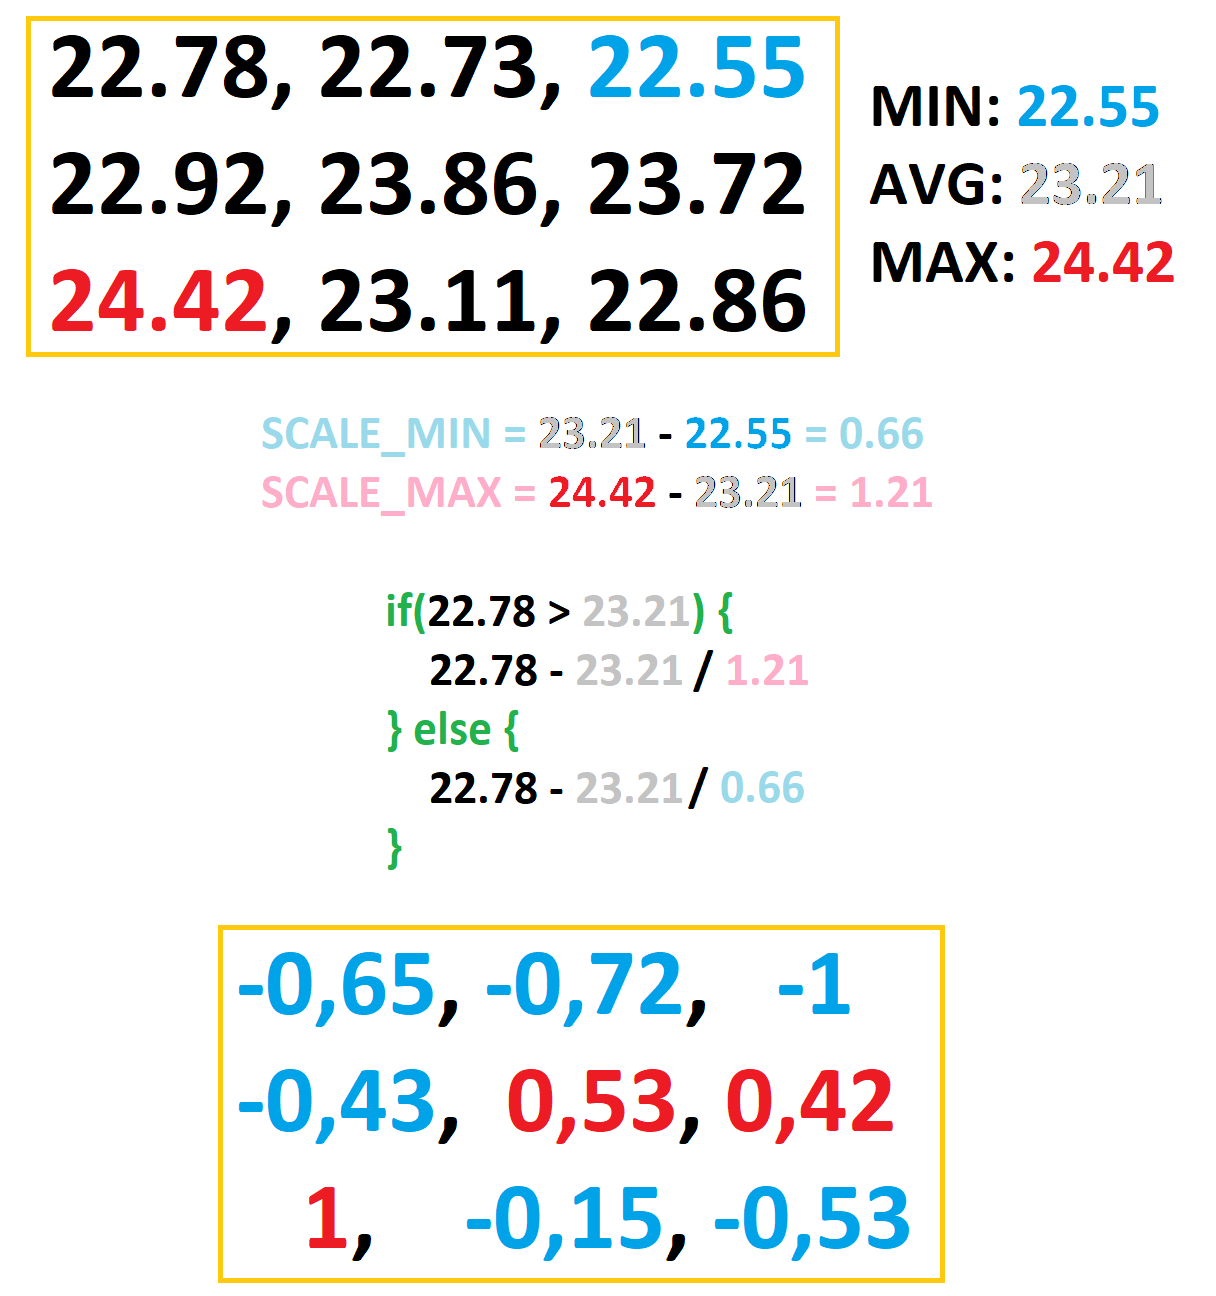

In [4]:
"""
Функция масштабирует все значения температур относительно среднего.

Параметры:
    buffer_temp (np.ndarray): двумерный массив (24×32) с температурами.

Возвращает:
    buffer_scale (np.ndarray): массив той же формы с отмасштабированными значениями.
"""
def temp_to_scale(buffer_temp: np.ndarray) -> np.ndarray:
    # Получаем статистику: min, avg, max
    min_val = np.min(buffer_temp)
    max_val = np.max(buffer_temp)
    avg_val = np.mean(buffer_temp)

    # Коэффициенты для масштабирования
    scale_min = avg_val - min_val
    scale_max = max_val - avg_val

    # Создаём пустой массив для результата
    buffer_scale = np.zeros_like(buffer_temp, dtype=np.float32)

    # Векторизованная (быстрая) реализация без двойного цикла
    lower_mask = buffer_temp < avg_val
    upper_mask = ~lower_mask  # всё, что >= avg_t

    buffer_scale[lower_mask] = (buffer_temp[lower_mask] - avg_val) / scale_min
    buffer_scale[upper_mask] = (buffer_temp[upper_mask] - avg_val) / scale_max

    # Масштабируем [-1, 1] → [-128, 127]
    buffer_scale = np.clip(buffer_scale, -1, 1)  # чтобы не выйти за границы
    buffer_scale = (buffer_scale * 127).astype(np.int8)
    
    return buffer_scale

### Отмасштабировать все термоизображения

In [5]:
list_X = []
for i in range(X_data.shape[0]):
    list_X.append(temp_to_scale(X_data[i]))

X_data = np.array( list_X )

### Разделить тренировочные данные на две части и рандомно перемешать

In [6]:
from sklearn.model_selection import train_test_split

# Разделим датасет на две части.
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_binary, train_size = 0.8)

print(X_train.shape)
print(Y_train.shape)

(120, 24, 32, 1)
(120, 3)


# СВЁРТОЧНЫЕ НЕЙРОННЫЕ СЕТИ
**Свёрточная нейронная сеть — это особый тип реализации искусственного интеллекта, который использует специальную математическую операцию, называемую свёрткой, для обработки данных из изображений.**

* **Свёртка выполняется путём перемножения двух матриц и получения третьей, меньшей матрицы.**
* **Сеть принимает входное изображение и использует фильтр (или ядро) для создания карты признаков, описывающей изображение.**
* **В операции свёртки фильтр (обычно матрица 2x2 или 3x3) скользит по матрице изображения. Соответствующие числа в обеих матрицах перемножаются и складываются, образуя одно число, описывающее данный участок изображения. Этот процесс повторяется для всего изображения. Принцип работы показан на следующей иллюстрации.**

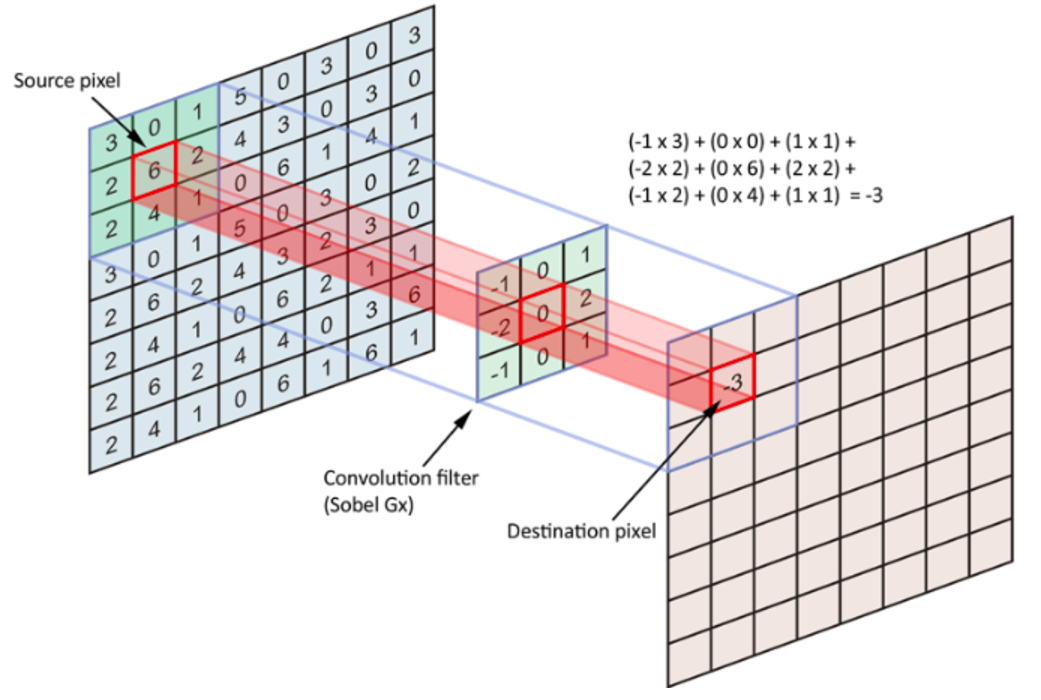

# Обучение модели CNN

In [7]:
# Библиотека для создания и обучения моделей глубокого обучения.
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [8]:
# Определим объект для динамической настройки скорости обучения (learning rate) во время тренировки модели.
    # monitor: параметр указывает, какую метрику следует отслеживать для принятия решения о снижении скорости обучения.
    # patience = 2: Если в течение двух эпох не будет улучшений, скорость обучения будет уменьшена.
    # verbose = 1: Если установлен в 1, то в консоль будут выводиться сообщения о снижении скорости обучения.
    # factor=0.25: Это коэффициент, на который будет умешаться текущая скорость обучения, если не наблюдается улучшения.
    # min_lr: Это минимально допустимое значение для скорости обучения.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 8, verbose=1, factor=0.5, min_lr=0.000001)

### Модель

In [9]:
# Инициализация модели.
model_CNN = Sequential()

# 1-й свёрточный слой (вход молели).
model_CNN.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
# Слой максимального пулинга для 1-го свёрточного слоя.
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# 2-й свёрточный слой.
model_CNN.add(Conv2D(8 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# Отключить 20% случайных нейронов в слое во время обучения. 
#model_CNN.add(Dropout(0))
# Слой максимального пулинга для 2-го свёрточного слоя.
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# Cлой для преобразования многомерных данных в одномерный вектор. 
model_CNN.add(Flatten())

# 1-й полносвязный слой.
model_CNN.add(Dense(units = 16 , activation = 'relu'))
# Отключить 30% случайных нейронов в слое во время обучения. 
model_CNN.add(Dropout(0))

# 2-й полносвязный слой (выход модели).
model_CNN.add(Dense(units = NUM_of_LABELS , activation = 'softmax'))

# Собрать модель.
    # optimizer: оптимизатор, который будет использоваться для обновления весов модели во время обучения.
    # loss: функция потерь, которая будет использоваться для оценки качества предсказаний модели. 
    # metrics: метрика, которая будет отслеживаться во время обучения и валидации чтобы понять, насколько хорошо модель работает на данных.
model_CNN.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# Вывод текстового представления структуры модели нейронной сети. 
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 32, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 16, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 8, 8)           0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 16)                6

# Обучение модели

In [10]:
# Кол-во итераций обучения.
Epochs = 20

# Запустить обучение модели.
history = model_CNN.fit(X_train, Y_train, epochs = Epochs, validation_data = (X_test, Y_test), callbacks = [learning_rate_reduction])

# Сохранить модель.
model_CNN.save('model_CNN.h5')

Epoch 1/20
4/4 [==============================] - 1s 49ms/step - loss: 14.8981 - accuracy: 0.3833 - val_loss: 7.5415 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
4/4 [==============================] - 0s 11ms/step - loss: 3.2280 - accuracy: 0.6000 - val_loss: 2.7487 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/20
4/4 [==============================] - 0s 10ms/step - loss: 2.5467 - accuracy: 0.5583 - val_loss: 1.9605 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 4/20
4/4 [==============================] - 0s 10ms/step - loss: 1.3237 - accuracy: 0.6833 - val_loss: 0.6271 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 5/20
4/4 [==============================] - 0s 10ms/step - loss: 0.7219 - accuracy: 0.7667 - val_loss: 0.7702 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 6/20
4/4 [==============================] - 0s 10ms/step - loss: 0.4913 - accuracy: 0.8000 - val_loss: 0.4291 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 7/20
4/4 [==============================] - 0s 10ms/step - loss: 0.2977 - accurac

C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Оценим качество обученой модели сравнив предсказания с правильными ответами.
print("Accuracy of the model is - " , model_CNN.evaluate(X_test, Y_test)[1]*100 , "%")

1/1 [==============================] - 0s 17ms/step - loss: 0.0041 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


# Анализ процесса обучения модели

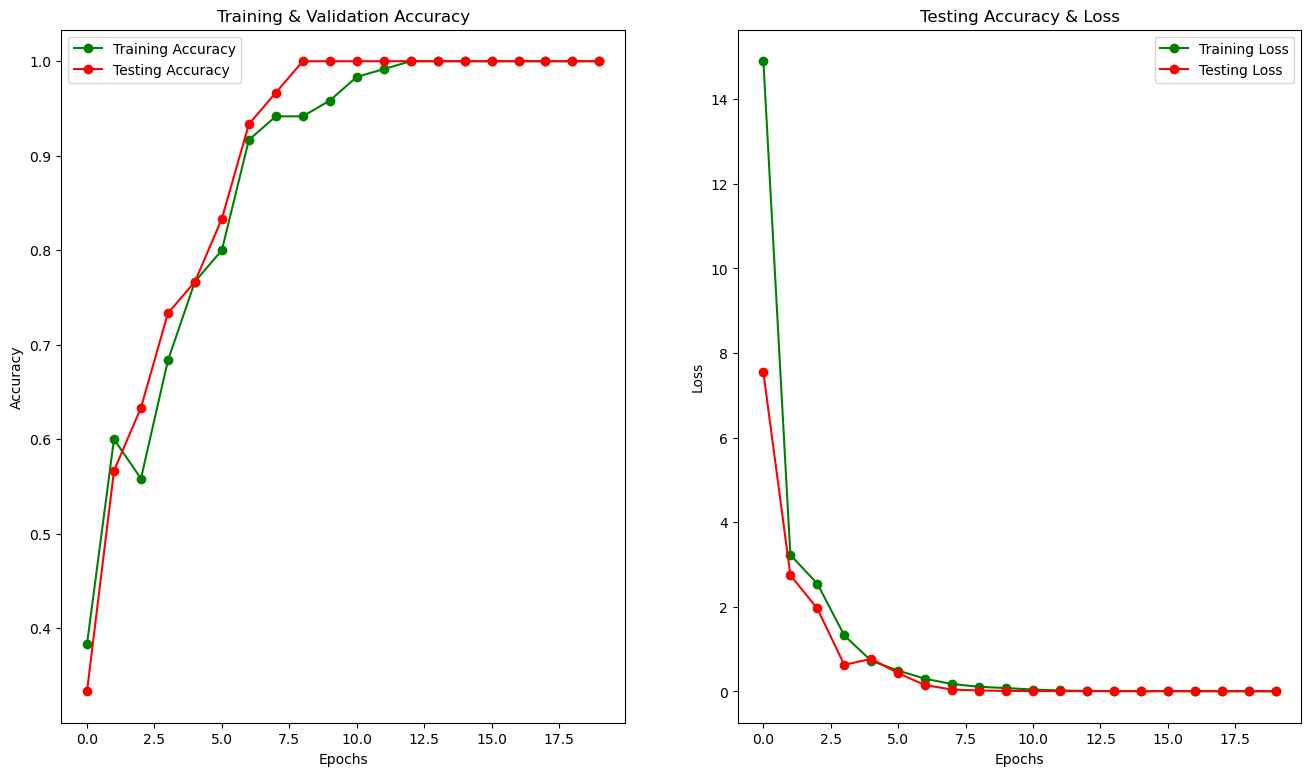

In [12]:
epochs = [i for i in range(Epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Конвертируем модель в облегчённый формат
### Подготавливаем репрезентативную выборку

In [13]:
def representative_dataset():
    for i in range(len(X_train)):
        # Оборачиваем каждую строку в batch размером (1, 24, 32)
        #data = np.expand_dims(X_train[i], axis=0).astype(np.float32)
        data = np.expand_dims(X_train[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), axis=0).astype(np.float32)
        yield [data]

### Конвертируем модель

In [14]:
# Платформа для машинного обучения, разработанная Google, которая предоставляет инструменты для создания, 
# обучения и развертывания моделей машинного и глубокого обучения
import tensorflow as tf

# Передаём модель в конвертер.
converter = tf.lite.TFLiteConverter.from_keras_model(model_CNN)

# Передаём репрезентативную выборку в конвертер.
converter.representative_dataset = representative_dataset

# Указываем оптимизатор для модели.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Передаём набор встроенных операций, которые поддерживают 8-битные целочисленные (от -128 до 127) вычисления. 
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Указываем что вход модели отныне принимает 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_input_type = tf.int8
# Указываем что выход модели отныне выдаёт 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\STEPAN~1\AppData\Local\Temp\tmpuec2hbqh\assets


INFO:tensorflow:Assets written to: C:\Users\STEPAN~1\AppData\Local\Temp\tmpuec2hbqh\assets
C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [15]:
# Сохранить облегчённую модель.
open("model_CNN.tflite", "wb").write(tflite_model)

12168

##### Команда для текстового редактора "vim" чтобы преобразовать бинарный файл в C/C++ формат, который можно использовать как массив байтов в исходном коде для ESP32.

#### xxd -i model_CNN.tflite > model.cc

### Оценим качество облегчённой модели

In [16]:
# Путь к сохранённой облегчённой модели.
tflite_model_path = "model_CNN.tflite"

# Загрузка модели и выделение памяти под тензоры.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Получить входной и выходной тензоры.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Параметры для масштабирования 
input_scale, input_zero_point = input_details[0]['quantization']

# Вывести размеры входного и выходного тензора.
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[ 1 24 32  1]
[1 3]


In [17]:
input_scale, input_zero_point = input_details[0]['quantization']
print(input_scale)
print(input_zero_point)

0.9960784316062927
-1


In [18]:
# Список для всех предсказаний.
predictions = []

Y_test = np.array(Y_test)

# Предскажем классы для всей тестовой выборки.
for i in range(X_test.shape[0]):
    # Передаём данные(отмасштабируем данные [0 : 100] --> [-128 : 127]).
    #X_input = np.int8(((X_test[i]-50)/50)*127.5).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
    X_input = X_test[i]
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X_input, axis=0))
    interpreter.invoke()
    # Получаем результат.
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    # Сохраним предсказания.
    predictions.append(tflite_model_predictions[0])
    
    print("Prediction ", i, ": ", tflite_model_predictions[0])
    predicted = np.argmax(tflite_model_predictions, axis=1)[0]
    print("predicted_class:",predicted,"( ", Y_binary.columns[predicted], " )")
    correct = np.argmax(Y_test[i])
    print("correct_class:",correct,"( ", Y_binary.columns[correct], " )")
    print("------------------------------------")

Prediction  0 :  [-128  127 -128]
predicted_class: 1 (  Empty  )
correct_class: 1 (  Empty  )
------------------------------------
Prediction  1 :  [-127 -128  127]
predicted_class: 2 (  Human  )
correct_class: 2 (  Human  )
------------------------------------
Prediction  2 :  [ 127 -128 -128]
predicted_class: 0 (  Cat  )
correct_class: 0 (  Cat  )
------------------------------------
Prediction  3 :  [-128  127 -128]
predicted_class: 1 (  Empty  )
correct_class: 1 (  Empty  )
------------------------------------
Prediction  4 :  [-128  127 -128]
predicted_class: 1 (  Empty  )
correct_class: 1 (  Empty  )
------------------------------------
Prediction  5 :  [ 127 -128 -128]
predicted_class: 0 (  Cat  )
correct_class: 0 (  Cat  )
------------------------------------
Prediction  6 :  [ 127 -128 -128]
predicted_class: 0 (  Cat  )
correct_class: 0 (  Cat  )
------------------------------------
Prediction  7 :  [-128  127 -128]
predicted_class: 1 (  Empty  )
correct_class: 1 (  Empty  )
-

In [19]:
# Оценим качество облегчённой модели сравнив предсказания с правильными ответами.
from sklearn.metrics import accuracy_score
acc = accuracy_score(np.argmax(predictions, axis=1), np.argmax(Y_test, axis=1))

print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 1.0
